# Viagogo Case Study - Alokik Mishra 

## Question 1 

### Setting up the data

In [25]:
## Basic data manipulation and visualization packages
import numpy as np
import pandas as pd
import datetime
from Utils import *
import matplotlib.pyplot as plt

## Scikit-learn data packages
from sklearn.utils import resample
from sklearn.preprocessing import PolynomialFeatures
from sklearn import metrics
from sklearn.model_selection import train_test_split

## Scikit-learn predictive models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import tree
from sklearn.naive_bayes import GaussianNB

## Statistics packages for logistic regression with standard errors
import statsmodels.discrete.discrete_model as sm

## Visualization package for fitted models
import seaborn as sns

## Used to create decision tree visalization (need to have software installed : https://www.graphviz.org/d)
import graphviz

## Turning off future warning
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [26]:
P1 = ABTest(name = "Assignment 1", raw_data = "Spring 2018 - Product Case Data.xlsx") ## Intializing object
P1.read() # Reading excel file
P1.clean_date(date_var = 'Date') # Formatting date and creating a date integer variable
P1.data.head()

,Date,Channel,User Type,Land,Bounce,Purchase,Visitors_Control,Visitors_Variant,Date_int
0,2014-10-10,Affiliate,Returning User,0,0,0,1211,1175,0
1,2014-10-10,Affiliate,Returning User,1,0,0,4076,4810,0
2,2014-10-10,Affiliate,Returning User,1,1,0,2766,3386,0
3,2014-10-10,Affiliate,Returning User,0,0,1,196,159,0
4,2014-10-10,Affiliate,Returning User,1,0,1,358,332,0


In [27]:
## Reshaping the data to 'stack' control and variant into one column
P1.reshape_long(value_cols= ['Visitors_Control','Visitors_Variant'], 
                id_names = "Treatment", value_names = "Traffic",
               make_dummy = True, val_if_true = "Visitors_Variant")

## Creating a numeric version of the dataframe which turns all categorical vars into dummies
P1.make_df_numeric()
P1.make_weekend(date_var = 'Date') ## Creates a binary equal to one if it is the weekend
P1.long_df.head()

,Date,Channel,User Type,Land,Bounce,Purchase,Date_int,Treatment,Traffic,Weekend
0,2014-10-10,Affiliate,Returning User,0,0,0,0,False,1211,0.0
1,2014-10-10,Affiliate,Returning User,1,0,0,0,False,4076,0.0
2,2014-10-10,Affiliate,Returning User,1,1,0,0,False,2766,0.0
3,2014-10-10,Affiliate,Returning User,0,0,1,0,False,196,0.0
4,2014-10-10,Affiliate,Returning User,1,0,1,0,False,358,0.0


## EDA 

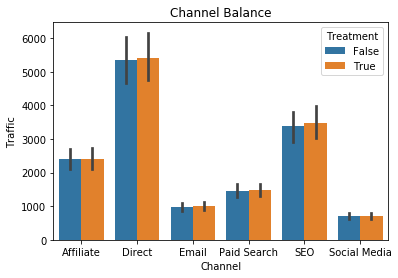

In [28]:
## Comparing and checking for balance in distribution of consumer traffic across diffrent channels
P1.bar_graph(x = "Channel", y = "Traffic", hue = "Treatment",
            title = "Channel Balance", save_name = "Images/Channel_Balance.png")

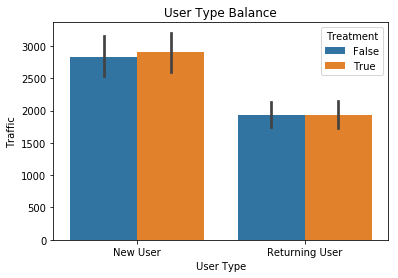

In [29]:
## Comparing and checking for balance in distribution of consumer traffic across diffrent user types
P1.bar_graph(x = "User Type", y = "Traffic", hue = "Treatment",
            title = "User Type Balance", save_name = "Images/User_Balance.png")

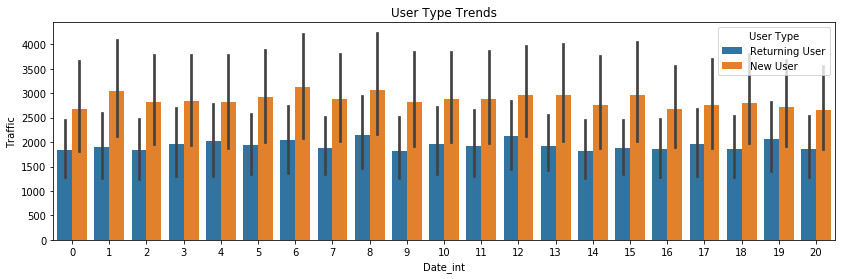

In [30]:
P1.bar_graph(x = "Date_int", y = "Traffic", hue = "User Type",
            title = "User Type Trends", fig_size = (14, 4), save_name = "Images/User_typetrends.png")

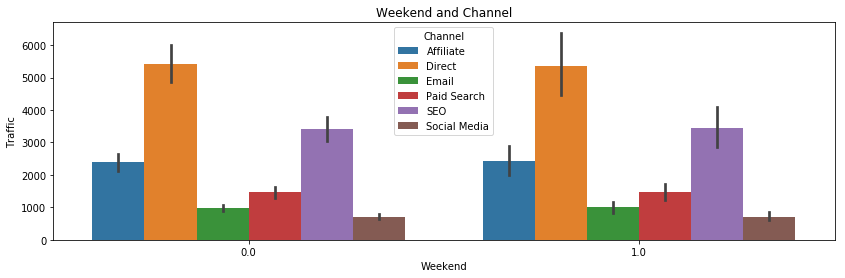

In [31]:
P1.bar_graph(x = "Weekend", y = "Traffic", hue = "Channel",
            title = "Weekend and Channel", fig_size = (14, 4), save_name = "Images/channel_weekend.png")

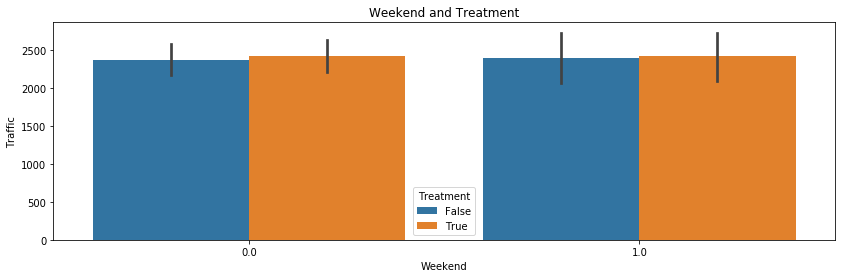

In [32]:
P1.bar_graph(x = "Weekend", y = "Traffic", hue = "Treatment",
            title = "Weekend and Treatment", fig_size = (14, 4), save_name = "Images/treatment_weekend.png")

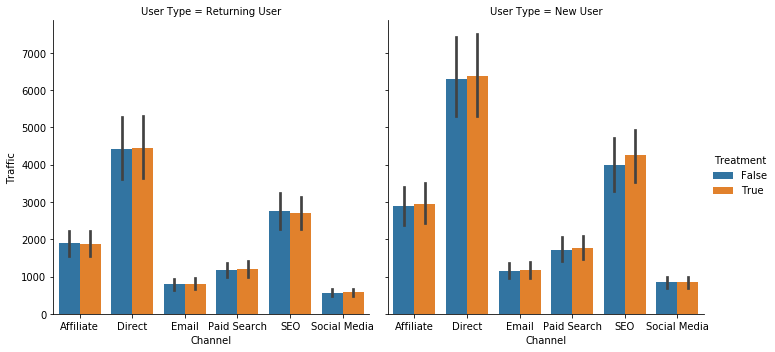

In [38]:
sns.catplot(x="Channel", y="Traffic", hue = "Treatment", col = "User Type", kind = 'bar', data=P1.long_df)
plt.savefig('Images/UserType_Treatment_Balance.png')

### Conversion Rate 

In [14]:
## Conversion rates by treatment
ConvRate = P1.calc_rates(calc_name = "ConvRate", value_var = "Traffic", grouping_vars = ["Treatment", "Purchase"])
ConvRate

Purchase,0,1,ConvRate
Treatment,,,
0,2829794,166543,0.055582
1,2884267,161586,0.053051


### Bounce Rate

In [10]:
## Bounce rates by treatment
BounceRate = P1.calc_rates(calc_name = "BounceRate", value_var = "Traffic", 
                           grouping_vars = ["Treatment", "Bounce"],
                          constraint_var = ["Land"], constraint_val = [1])
BounceRate

Bounce,0,1,BounceRate
Treatment,,,
0,1571312,1032963,0.396641
1,1557717,1094416,0.412655


### Conversion and Bounce Over Time 

In [11]:
## Bounce and Conversion rates by treatment and date
ConvRateDate = P1.calc_rates(calc_name = "ConvRate", value_var = "Traffic", 
                             grouping_vars = ["Date","Treatment", "Purchase"]).reset_index(level = ['Date', 'Treatment'])

BounceRateDate = P1.calc_rates(calc_name = "BounceRate", value_var = "Traffic", 
                           grouping_vars = ["Date", "Treatment", "Bounce"],
                          constraint_var = ["Land"], constraint_val = [1]).reset_index(level = ['Date', 'Treatment'])

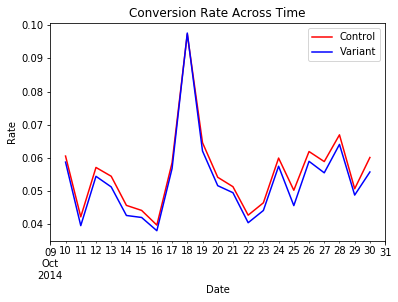

In [12]:
## Plotting conversion rate across time
P1.timeplot(data = ConvRateDate, col_key = {0:'Red', 1:'Blue'}, 
            lab_key = {0:'Control', 1:'Variant'}, split_var = "Treatment",
            x = 'Date', y= "ConvRate", 
            x_lab = "Date", y_lab = "Rate", 
            title ="Conversion Rate Across Time", save_name = "Images/Convrate.png")

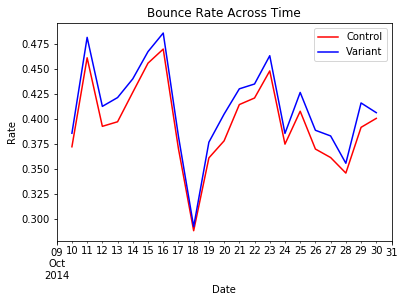

In [13]:
## Plotting bounce rate over time
P1.timeplot(data = BounceRateDate, col_key = {0:'Red', 1:'Blue'}, 
            lab_key = {0:'Control', 1:'Variant'}, split_var = "Treatment",
            x = 'Date', y= "BounceRate", 
            x_lab = "Date", y_lab = "Rate", 
            title ="Bounce Rate Across Time", save_name = "Images/Bouncerate.png")

### Conditional Raw Comparision

In [14]:
covars = ['Channel_Affiliate','Channel_Direct','Channel_Email','Channel_Paid Search','Channel_SEO',
 'Channel_Social Media','User Type_New User','User Type_Returning User'] ## Variables to conditon conversion rates
partitioned = {} # Intializing dictionary to be used later

## Creating a set tables with conversion rates condiioned on the co-variates above.
for i in covars:
    partitioned[i] = P1.calc_rates(calc_name = "ConvRate", 
                             value_var = "Traffic", 
                             grouping_vars = ["Date","Treatment", "Purchase"], 
                             constraint_var = [i], constraint_val = [1]).reset_index(level = ['Date', 'Treatment'])

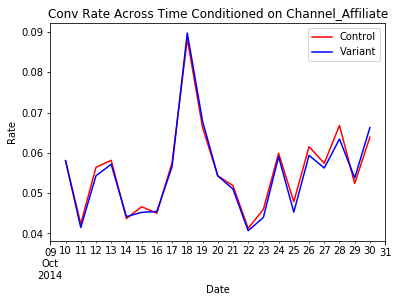

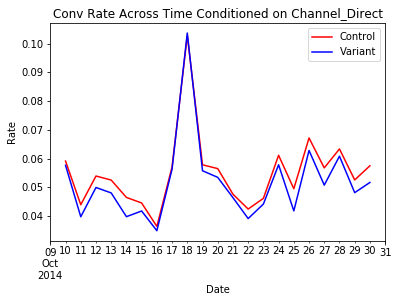

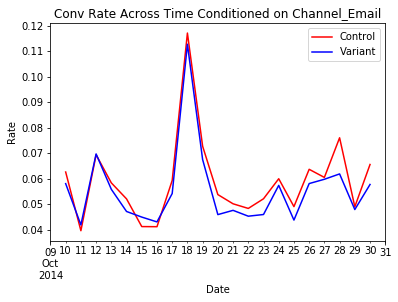

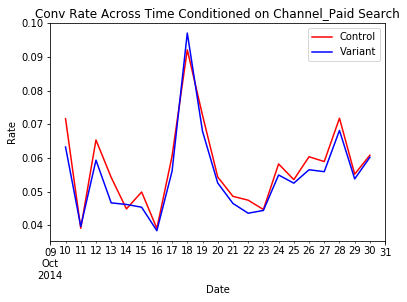

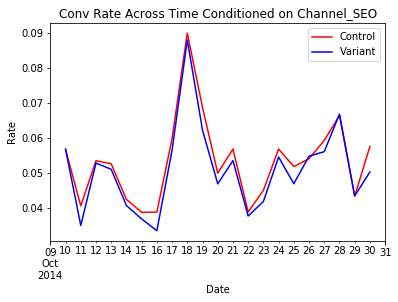

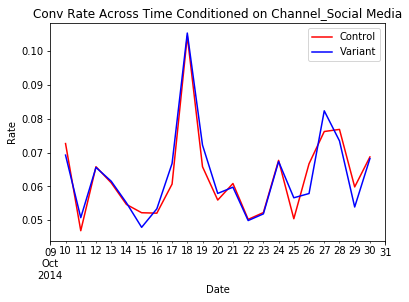

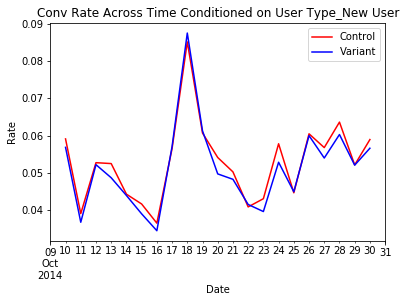

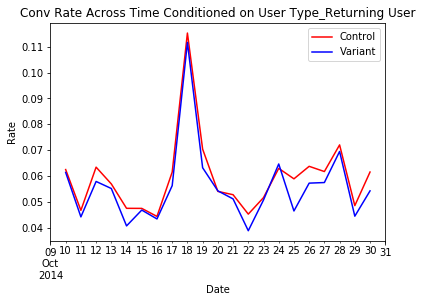

In [15]:
## Plotting all the raw trends
for key in partitioned.keys():
    P1.timeplot(data = partitioned[key], col_key = {0:'Red', 1:'Blue'}, 
            lab_key = {0:'Control', 1:'Variant'}, split_var = "Treatment",
            x = 'Date', y= "ConvRate", 
            x_lab = "Date", y_lab = "Rate", 
            title ="Conv Rate Across Time Conditioned on " + key , save_name = "Images/Convrate_"+key+".png")

### Conditional Time Trends

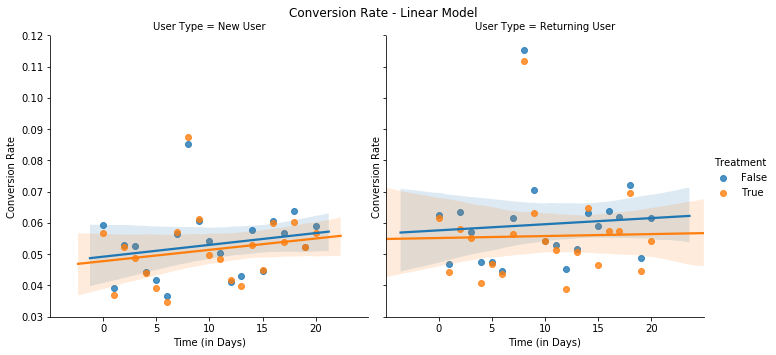

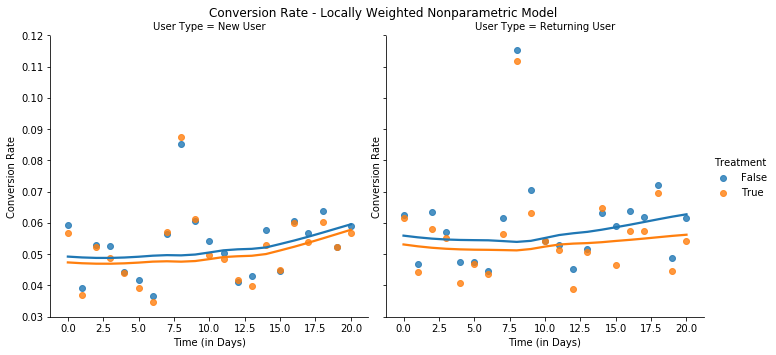

In [16]:
## Conversion rates conditional on user type (same as above)
ConvRate_user = P1.calc_rates(calc_name = "ConvRate", value_var = "Traffic", 
                         use_numeric = False, 
                         grouping_vars = ["Date_int","User Type",
                                          "Treatment", "Purchase"]).reset_index(level = ['Date_int', 
                                                                                         'User Type',
                                                                                      'Treatment'])

## Plotting the linear ols estimated trends (not raw) across time condtitional on user type
P1.estplot(data = ConvRate_user, x = 'Date_int', y = 'ConvRate',
           hue = 'Treatment', col = 'User Type', lowess = False,
           axis_labels = ['Time (in Days)', 'Conversion Rate'],
           title = 'Conversion Rate - Linear Model',
           save_name = 'images/Conv_estimation_linear_user.png')

## Plotting the locally weighted estimated trends and confidence intervals 
## (not raw) across time condtitional on user type
P1.estplot(data = ConvRate_user, x = 'Date_int', y = 'ConvRate',
           hue = 'Treatment', col = 'User Type', lowess = True,
           axis_labels = ['Time (in Days)', 'Conversion Rate'],
           title = 'Conversion Rate - Locally Weighted Nonparametric Model',
           save_name = 'images/Conv_estimation_user.png')

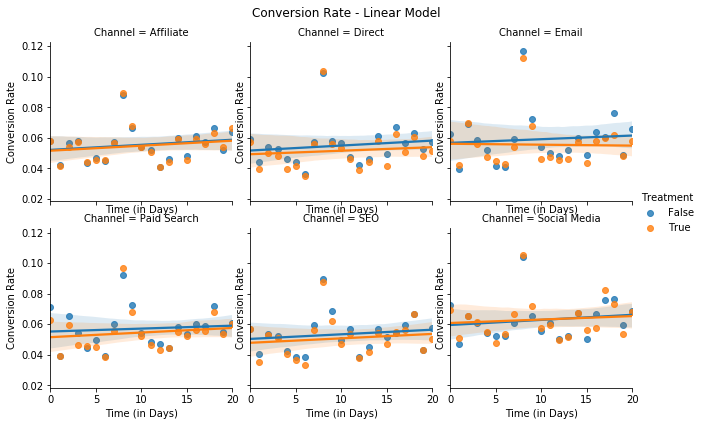

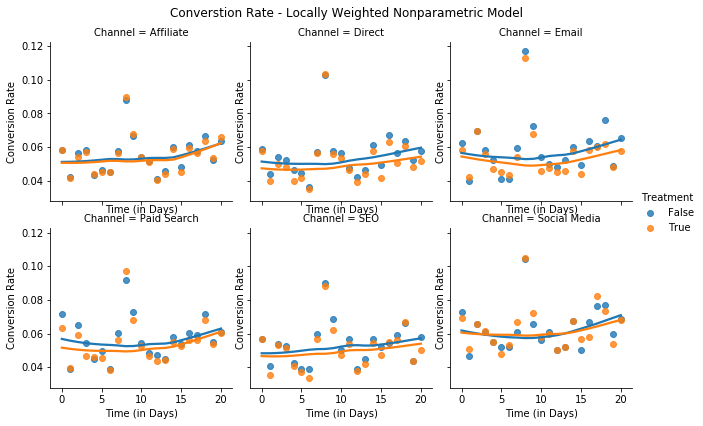

In [17]:
## Conversion rates conditional on channel (same as above)
ConvRate_channel = P1.calc_rates(calc_name = "ConvRate", value_var = "Traffic", 
                         use_numeric = False, 
                         grouping_vars = ["Date_int","Channel",
                                          "Treatment", "Purchase"]).reset_index(level = ['Date_int', 
                                                                                         'Channel',
                                                                                         'Treatment'])

## Plotting the linear ols estimated trends (not raw) across time condtitional on channel
P1.estplot(data = ConvRate_channel, x = 'Date_int', y = 'ConvRate',
           hue = 'Treatment', col = 'Channel', lowess = False,
           axis_labels = ['Time (in Days)', 'Conversion Rate'],
           title = 'Conversion Rate - Linear Model',
           save_name = 'images/Conv_estimation_linear_channel.png',
           custom = True, col_wrap = 3, height = 3, x_lim = (0,20))

## Plotting the locally weighted estimated trends and confidence intervals 
## (not raw) across time condtitional on channel
P1.estplot(data = ConvRate_channel, x = 'Date_int', y = 'ConvRate',
           hue = 'Treatment', col = 'Channel', lowess = True,
           axis_labels = ['Time (in Days)', 'Conversion Rate'],
           title = 'Converstion Rate - Locally Weighted Nonparametric Model',
           save_name = 'images/Conv_estimation_channel.png',
           custom = True, col_wrap = 3, height = 3)

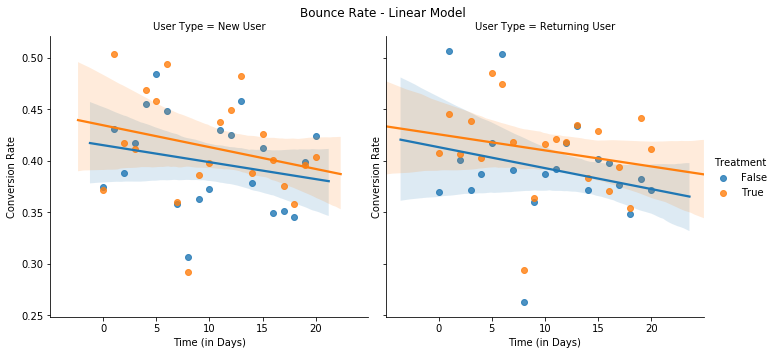

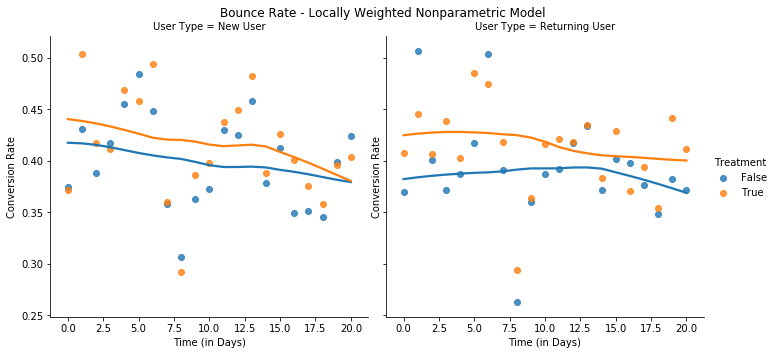

In [18]:
BounceRate_user = P1.calc_rates(calc_name = "BounceRate", value_var = "Traffic",
                           use_numeric = False,
                           grouping_vars = ["Date_int", "User Type",
                                            "Treatment", "Bounce"],
                          constraint_var = ["Land"], constraint_val = [1]).reset_index(level = ['Date_int',
                                                                                                'User Type',
                                                                                                'Treatment'])

## Plotting the linear ols estimated trends (not raw) across time condtitional on user type
P1.estplot(data = BounceRate_user, x = 'Date_int', y = 'BounceRate',
           hue = 'Treatment', col = 'User Type', lowess = False,
           axis_labels = ['Time (in Days)', 'Conversion Rate'],
           title = 'Bounce Rate - Linear Model',
           save_name = 'Images/Bounce_estimation_linear_user.png')

## Plotting the locally weighted estimated trends and confidence intervals 
## (not raw) across time condtitional on user type
P1.estplot(data = BounceRate_user, x = 'Date_int', y = 'BounceRate',
           hue = 'Treatment', col = 'User Type', lowess = True,
           axis_labels = ['Time (in Days)', 'Conversion Rate'],
           title = 'Bounce Rate - Locally Weighted Nonparametric Model',
           save_name = 'Images/Bounce_estimation_user.png')

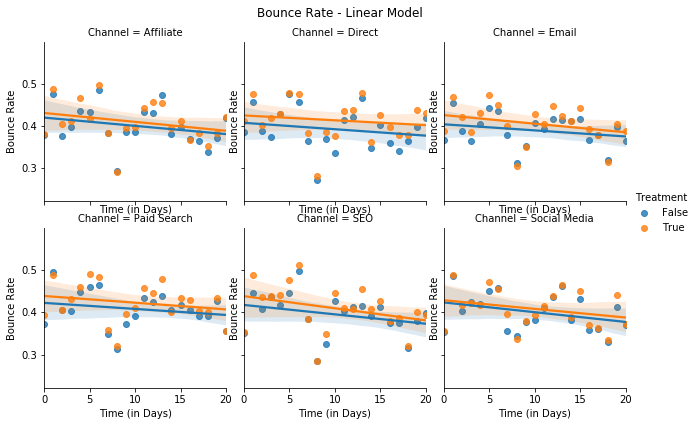

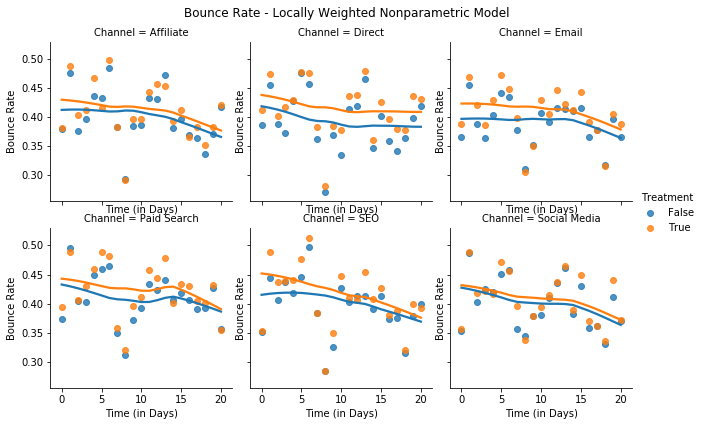

In [39]:
BounceRate_channel = P1.calc_rates(calc_name = "BounceRate", value_var = "Traffic",
                           use_numeric = False,
                           grouping_vars = ["Date_int", "Channel",
                                            "Treatment", "Bounce"],
                          constraint_var = ["Land"], constraint_val = [1]).reset_index(level = ['Date_int',
                                                                                                'Channel',
                                                                                                'Treatment'])

## Plotting the linear ols estimated trends (not raw) across time condtitional on user type
P1.estplot(data = BounceRate_channel, x = 'Date_int', y = 'BounceRate',
           hue = 'Treatment', col = 'Channel', lowess = False,
           axis_labels = ['Time (in Days)', 'Bounce Rate'],
           title = 'Bounce Rate - Linear Model',
           save_name = 'images/Bounce_estimation_linear_channel.png',
           custom = True, col_wrap = 3, height = 3, x_lim = (0,20))

## Plotting the locally weighted estimated trends and confidence intervals 
## (not raw) across time condtitional on user type
P1.estplot(data = BounceRate_channel, x = 'Date_int', y = 'BounceRate',
           hue = 'Treatment', col = 'Channel', lowess = True,
           axis_labels = ['Time (in Days)', 'Bounce Rate'],
           title = 'Bounce Rate - Locally Weighted Nonparametric Model',
           save_name = 'images/Bounce_estimation_channel.png',
           custom = True, col_wrap = 3, height = 3)

## Individual Analysis - Data Prep

In [40]:
## For this part I break the data down into individual users rather than aggregated data
## The outcome now becomes purchase itself rather than rates.
P2 = AB_analysis(name = "Question 1 D", raw_data = "Spring 2018 - Product Case Data.xlsx") ## Initializing object
P2.read()
P2.clean_date(date_var = 'Date')
P2.reshape_long(value_cols= ['Visitors_Control','Visitors_Variant'], 
                id_names = "Treatment", value_names = "Traffic",
               make_dummy = True, val_if_true = "Visitors_Variant")
P2.make_weekend(date_var = 'Date') ## Creates a binary equal to one if it is the weekend
P2.make_df_numeric()
P2.expand(repeat_col = "Traffic") ## Expands each observation by the number in the traffic columns 
                                  ## to account for each individual as a unique observation                                
P2.order_t("Treatment") ## Places treatment in the first column (just for aesthetic purposes)
P2.downsample(majority_label = 0) ## Downsamples the majority case (no purchase) to balance the outcome classes
P2.bootstrap(majority_label = 0, seeds = [123, 456, 789]) ## Bootstraps for robustness check on estimates
P2.make_day_indicator(day = 8) ## Creates a binary variable for the one outlier day October 18th

### Average Treatment Effect 

In [41]:
## Average treatment effect across the entire sample
X = P2.df_downsampled[['Treatment']].copy()
y = P2.df_downsampled[['Purchase']].copy()
print([X['Treatment'].value_counts(), y['Purchase'].value_counts()]) ## Checking balance of classes
LogitSM = sm.Logit(np.asarray(y.astype(int)),X.astype(int)) 
LogitSM.fit().summary()

[0    328569
1    327689
Name: Treatment, dtype: int64, 1    328129
0    328129
Name: Purchase, dtype: int64]
Optimization terminated successfully.
         Current function value: 0.693100
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               656258
Model:                          Logit   Df Residuals:                   656257
Method:                           MLE   Df Model:                            0
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:               6.844e-05
Time:                        22:13:42   Log-Likelihood:            -4.5485e+05
converged:                       True   LL-Null:                   -4.5488e+05
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Treatment     -0.0276      0.003     -7.891      0.000      -0.034      -0.021
==============================================================================
"""

The classes looks balanced

In [42]:
## Bootstrapped sample for robustness
X = P2.bootstrapped[['Treatment']].copy()
y = P2.bootstrapped[['Purchase']].copy()
print([X['Treatment'].value_counts(), y['Purchase'].value_counts()])
LogitSM = sm.Logit(np.asarray(y.astype(int)),X.astype(int))
LogitSM.fit().summary()

[0    985707
1    983067
Name: Treatment, dtype: int64, 1    984387
0    984387
Name: Purchase, dtype: int64]
Optimization terminated successfully.
         Current function value: 0.693100
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:              1968774
Model:                          Logit   Df Residuals:                  1968773
Method:                           MLE   Df Model:                            0
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:               6.844e-05
Time:                        22:13:46   Log-Likelihood:            -1.3646e+06
converged:                       True   LL-Null:                   -1.3647e+06
                                        LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Treatment     -0.0276      0.002    -13.667      0.000      -0.032      -0.024
==============================================================================
"""

### Weekend and Abnormal Day Interactions

In [43]:
## Interacting treatment with weekend
P2.logistic_with_interactions(treatment_var = 'Treatment', interaction_vars = ['Weekend'],
                                    y_var = 'Purchase', use_bootstrapped = False)

Optimization terminated successfully.
         Current function value: 0.692185
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               656258
Model:                          Logit   Df Residuals:                   656255
Method:                           MLE   Df Model:                            2
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:                0.001388
Time:                        22:13:48   Log-Likelihood:            -4.5425e+05
converged:                       True   LL-Null:                   -4.5488e+05
                                        LLR p-value:                5.316e-275
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Treatment     -0.0851      0.004    -20.320      0.000      -0.093      -0.077
TxWeekend      0.0377      0.010      3.807      0.000       0.018       0.057
Weekend        0.1521      0.006     24.010      0.000       0.140       0.164
==============================================================================
"""

In [44]:
## Interacting treatment with the outlier day only
P2.logistic_with_interactions(treatment_var = 'Treatment', interaction_vars = ['Abnormal_day'],
                                    y_var = 'Purchase', use_bootstrapped = False)

Optimization terminated successfully.
         Current function value: 0.689438
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               656258
Model:                          Logit   Df Residuals:                   656255
Method:                           MLE   Df Model:                            2
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:                0.005351
Time:                        22:13:49   Log-Likelihood:            -4.5245e+05
converged:                       True   LL-Null:                   -4.5488e+05
                                        LLR p-value:                     0.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Treatment         -0.0771      0.004    -21.262      0.000      -0.084      -0.070
TxAbnormal_day     0.0980      0.020      4.957      0.000       0.059       0.137
Abnormal_day       0.6193      0.014     45.228      0.000       0.592       0.646
==================================================================================
"""

### Social Media and Weekend Interactions

In [45]:
## Triple interaction with treatment, weekend and social media
P2.logistic_with_interactions(treatment_var = 'Treatment', interaction_vars = ['Weekend', 'Channel_Social Media'],
                                    y_var = 'Purchase', use_bootstrapped = False)

Optimization terminated successfully.
         Current function value: 0.692012
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               656258
Model:                          Logit   Df Residuals:                   656251
Method:                           MLE   Df Model:                            6
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:                0.001638
Time:                        22:13:52   Log-Likelihood:            -4.5414e+05
converged:                       True   LL-Null:                   -4.5488e+05
                                        LLR p-value:                     0.000
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Treatment                         -0.0972      0.004    -22.573      0.000      -0.106      -0.089
TxWeekend                          0.0468      0.010      4.598      0.000       0.027       0.067
TxChannel_Social Media             0.1081      0.026      4.164      0.000       0.057       0.159
TxWeekendxChannel_Social Media    -0.0535      0.048     -1.111      0.266      -0.148       0.041
Weekend                            0.1474      0.007     22.671      0.000       0.135       0.160
Channel_Social Media               0.1180      0.018      6.537      0.000       0.083       0.153
WeekendxChannel_Social Media      -0.0261      0.034     -0.766      0.444      -0.093       0.041
==================================================================================================
"""

### Time Interactions

In [26]:
## Triple interaction with treatment, date, and social media
P2.logistic_with_interactions(treatment_var = 'Treatment', interaction_vars = ['Date_int', 'Channel_Social Media'],
                                   other_vars = ['Abnormal_day'], y_var = 'Purchase', use_bootstrapped = False)

Optimization terminated successfully.
         Current function value: 0.689168
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:               656258
Model:                          Logit   Df Residuals:                   656250
Method:                           MLE   Df Model:                            7
Date:                Wed, 10 Apr 2019   Pseudo R-squ.:                0.005741
Time:                        15:03:28   Log-Likelihood:            -4.5227e+05
converged:                       True   LL-Null:                   -4.5488e+05
                                        LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Treatment                          -0.1567      0.007    -22.015      0.000      -0.171      -0.143
TxDate_int                          0.0068      0.001      9.951      0.000       0.005       0.008
TxChannel_Social Media              0.1926      0.042      4.564      0.000       0.110       0.275
TxDate_intxChannel_Social Media    -0.0096      0.004     -2.644      0.008      -0.017      -0.002
Date_int                            0.0004      0.000      1.219      0.223      -0.000       0.001
Channel_Social Media                0.0250      0.029      0.850      0.395      -0.033       0.083
Date_intxChannel_Social Media       0.0082      0.003      3.216      0.001       0.003       0.013
Abnormal_day                        0.6705      0.010     67.163      0.000       0.651       0.690
===================================================================================================
"""

## Predictive Models 

Now I try a series of classification models to predict the pruchasing decision of individuals. I train the model on 80% of the data, and then use the remainign 20% as a test set. The confusion matrix shows the combination of predicted and actual labels on the testing set. As can be seen most models perform in similar capacity at around 68%.

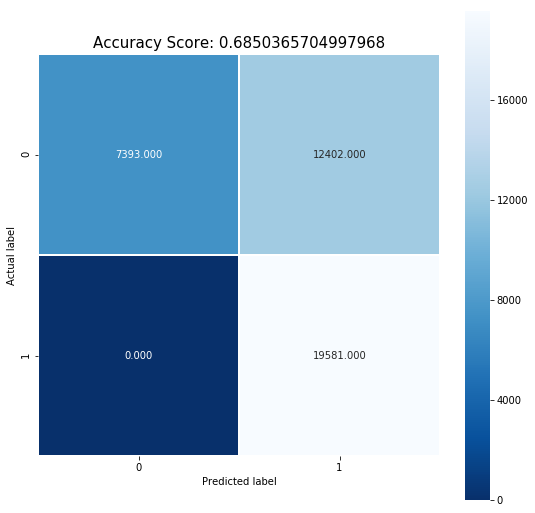

In [27]:
model1 = P2.fit_and_predict(predictor = LogisticRegression(solver='liblinear'), 
                y_col = 'Purchase', drop_cols = ['Date', 'Traffic'],
                use_bootstrapped = False, use_interactions = True, subsample = 0.3, 
                            save_name = 'Images/Logistics.png')

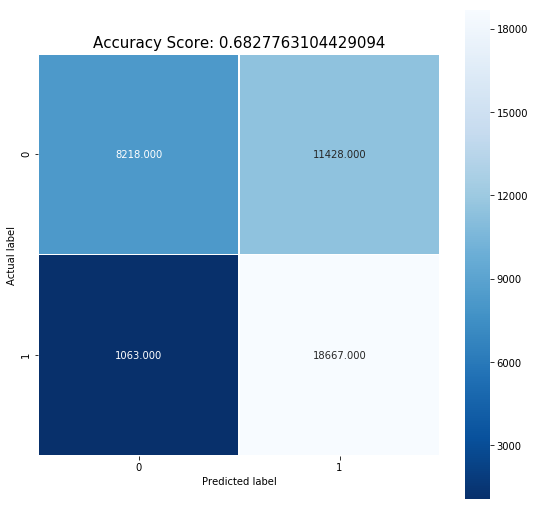

In [28]:
model2 = P2.fit_and_predict(predictor = tree.DecisionTreeClassifier(criterion="entropy"), 
                y_col = 'Purchase', drop_cols = ['Date', 'Traffic'],
                use_bootstrapped = False, use_interactions = True, subsample = 0.3, 
                            save_name = 'Images/Tree.png')

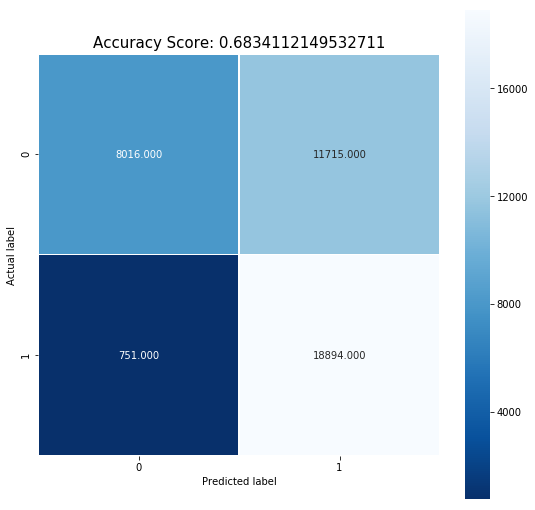

In [29]:
model3 = P2.fit_and_predict(predictor = RandomForestClassifier(n_estimators = 100), 
                y_col = 'Purchase', drop_cols = ['Date', 'Traffic'],
                use_bootstrapped = False, use_interactions = True, subsample = 0.3, 
                            save_name = 'Images/RF.png')

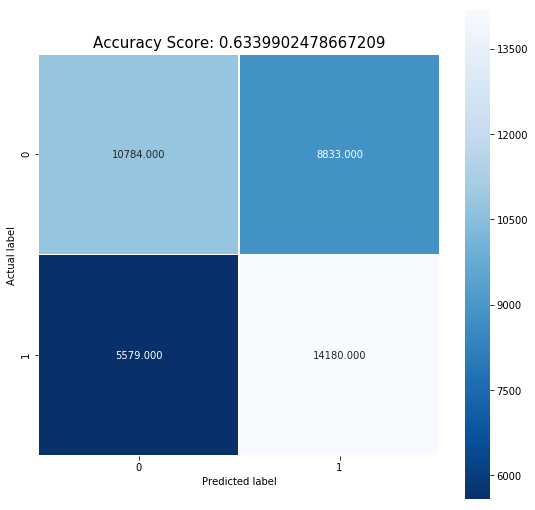

In [30]:
model4 = P2.fit_and_predict(predictor = KNeighborsClassifier(5), 
                y_col = 'Purchase', drop_cols = ['Date', 'Traffic'],
                use_bootstrapped = False, use_interactions = True, subsample = 0.3, 
                            save_name = 'Images/KNN.png')

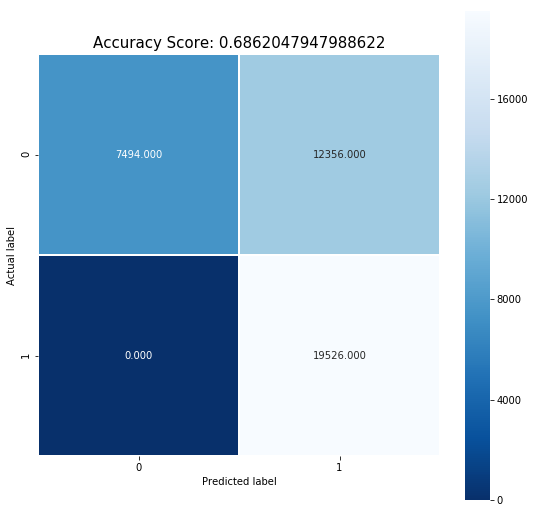

In [31]:
model5 = P2.fit_and_predict(predictor = MLPClassifier(hidden_layer_sizes=(100,100,100),alpha=1), 
                y_col = 'Purchase', drop_cols = ['Date', 'Traffic'],
                use_bootstrapped = False, use_interactions = True, subsample = 0.3, 
                            save_name = 'Images/MLP.png')

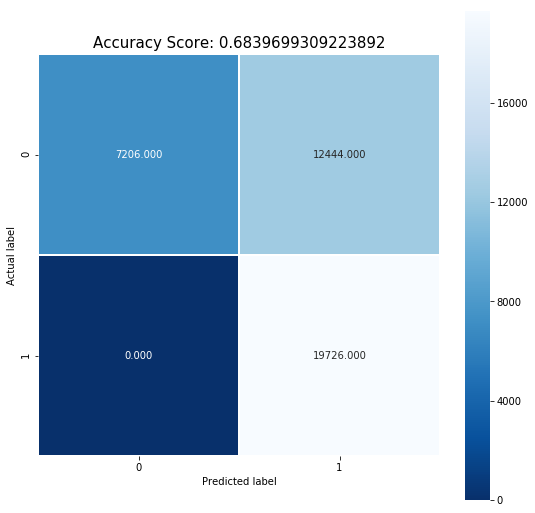

In [32]:
model7 = P2.fit_and_predict(predictor = GaussianNB(), 
                y_col = 'Purchase', drop_cols = ['Date', 'Traffic'],
                use_bootstrapped = False, use_interactions = True, subsample = 0.3, 
                            save_name = 'Images/NB.png')

## Tree Visualization

In [38]:
Break
## I do not reccomend running the code below unless you are familiar with graphviz.
## I just used it for the Tree vizualization.

NameError: name 'Break' is not defined

In [34]:
## Here I use just a few intersting variables to create a decision tree. 
## I leave out the bounce variable which otherwise dominates the weights. The model accuracy falls
## quite a bit. But the purpose of the excersise is to create the visualization and test the
## conditional importance of treatment.
df = P2.df_downsampled.copy()
X = df[['Land', 'Weekend', 'Channel_Social Media', 'User Type_New User', 'Treatment']].astype(int)
y = np.asarray(df[['Purchase']]).astype(int)
model_tree = tree.DecisionTreeClassifier(criterion="entropy").fit(X,y)
model_tree.score(X,y)

0.5504740513639452

In [36]:
import os
import matplotlib.image as mpimg
from scipy import ndimage
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/release/bin'
dotfile = open('Images/Decision_tree.dot', 'w')
tree.export_graphviz(model_tree, out_file = dotfile, 
                                feature_names = X.columns, 
                                 class_names = True,
                                filled = True,
                               rounded = True, special_characters = True)
dotfile.close()
os.system("dot -Tpng Images/Decision_tree.dot -o Images/Decision_tree.png")

0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


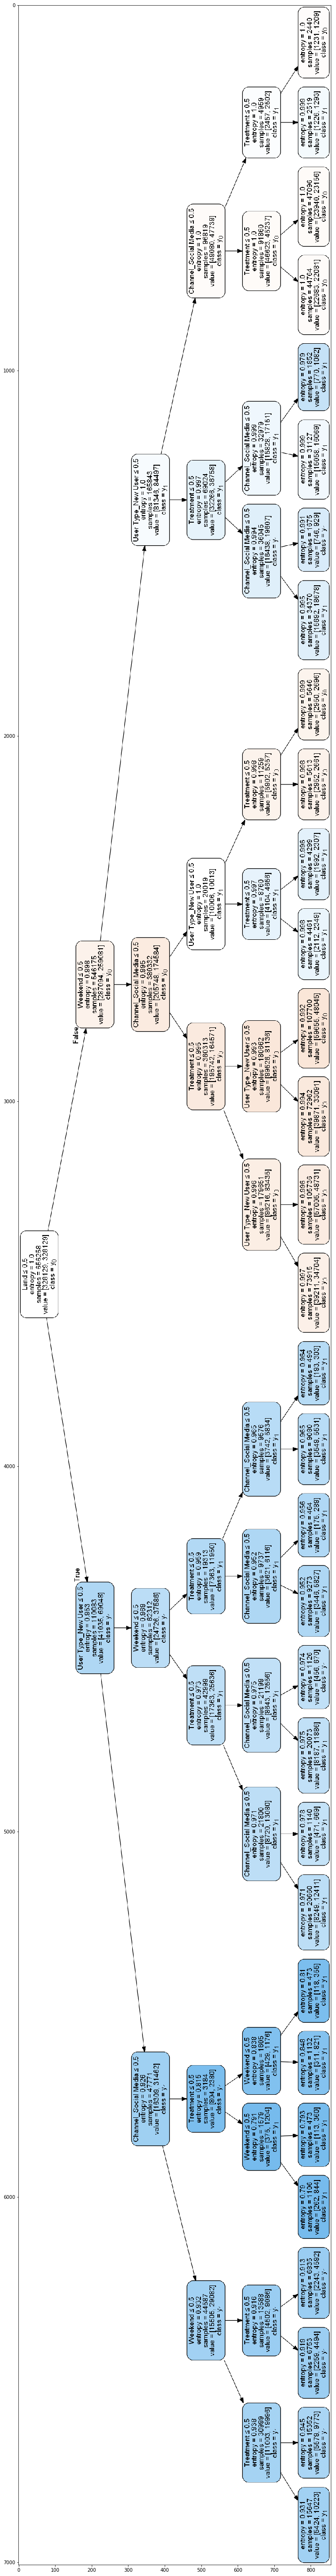

In [37]:

img = mpimg.imread('Images/Decision_tree.png')
plt.figure(figsize=(25,100))
rotated_img = ndimage.rotate(img, 90)
plt.imshow(rotated_img)